# Data Intern Challenge - Candidate: Renan Neri

This is Conta Stone's data challenge for intern applicants. The objective is to extract and analyze data from a database.

## Instructions

The solution can be developed using Python, SQL scripts, a BI tool or a combination of those. 
It must be sent as a compressed `.zip` folder including all the necessary files or hosted in a public code repository, such as **GitHub** or **GitLab**.

The database contains credit card transactional data in 4 tables:

- `customers`
- `cards`
- `transactions`
- `frauds`

1. Extract and analyze the data in the database in order to answer the following questions. Provide a description and/or comments for each solution.

- What is the average `age` of the customers in the database?
- How is the `card_family` ranked based on the `credit_limit` given to each card?
- For the transactions flagged as fraud, what are the `id`s of the transactions with the highest value?

2. Analysis:

- Analyze whether or not the fraudulent transactions are somehow associated to the other features of the dataset. Explain your results.

**It is not necessary to answer all questions.**

## Imports os libraries and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors     import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

ModuleNotFoundError: No module named 'sklearn'

In [227]:
cards = pd.read_csv("cards.csv", sep=";")
customers = pd.read_csv("customers.csv", sep=";")
frauds = pd.read_csv("frauds.csv", sep=";")
transactions = pd.read_csv("transactions.csv", sep=";")

## Data structure understandig

In [229]:
cards.head()

,card_number,card_family,credit_limit,customer_id
0,8638-5407-3631-8196,Premium,530000,CC67088
1,7106-4239-7093-1515,Gold,18000,CC12076
2,6492-5655-8241-3530,Premium,596000,CC97173
3,2868-5606-5152-5706,Gold,27000,CC55858
4,1438-6906-2509-8219,Platinum,142000,CC90518


In [230]:
customers.head()

,id,age,segment,vintage_group
0,CC25034,35,Diamond,VG1
1,CC59625,22,Diamond,VG1
2,CC69314,33,Diamond,VG1
3,CC67036,46,Diamond,VG1
4,CC25597,44,Diamond,VG1


In [231]:
frauds.head()

,transaction_id,fraud_flag
0,CTID50558449,True
1,CTID55936882,True
2,CTID63762180,True
3,CTID76723439,True
4,CTID21246201,True


In [232]:
frauds.describe()

,transaction_id,fraud_flag
count,109,109
unique,109,1
top,CTID12270763,True
freq,1,109


In [233]:
transactions.head()

,id,card_number,transaction_date,value,segment
0,CTID28830551,1629-9566-3285-2123,2016-04-24,23649,SEG25
1,CTID45504917,3697-6001-4909-5350,2016-02-11,26726,SEG16
2,CTID47312290,5864-4475-3659-1440,2016-11-01,22012,SEG14
3,CTID25637718,5991-4421-8476-3804,2016-01-28,37637,SEG17
4,CTID66743960,1893-8853-9900-8478,2016-03-17,5113,SEG14


Viewing the quantity of transactions and frauds

In [234]:
frauds.shape[0]

109

In [235]:
transactions.shape[0]

10000

Merging dataframes to become one dataframe and changing collums to numeric type.

In [236]:
transactions = transactions.merge(frauds, how='left',left_on="id", right_on="transaction_id", copy=False)
transactions = transactions.replace({'fraud_flag': np.nan, }, 0)
transactions = transactions.replace({'fraud_flag': True}, 1)
transactions = transactions.drop(columns=['transaction_id'])
transactions = transactions.merge(cards, how='left',left_on="card_number", right_on="card_number", copy=False)
transactions = transactions.merge(customers, how='left',left_on="customer_id", right_on="id", copy=False)
transactions = transactions.drop(columns=['id_y', 'segment_y'])
transactions = transactions.rename(columns={"id_x": "id", "segment_x": "segment"})
transactions['transaction_date'] = transactions['transaction_date'].astype('datetime64[ns]')
transactions["customer_id"] = pd.to_numeric(transactions["customer_id"].str.slice(start=2))
transactions["segment"] = pd.to_numeric(transactions["segment"].str.slice(start=3))
transactions["vintage_group"] = pd.to_numeric(transactions["vintage_group"].str.slice(start=2))
transactions["id"] = pd.to_numeric(transactions["id"].str.slice(start=4))


frauds = transactions.loc[transactions["fraud_flag"] > 0]

In [237]:
transactions.head()

,id,card_number,transaction_date,value,segment,fraud_flag,card_family,credit_limit,customer_id,age,vintage_group
0,28830551,1629-9566-3285-2123,2016-04-24,23649,25,0,Platinum,194000,24544,23,3
1,45504917,3697-6001-4909-5350,2016-02-11,26726,16,0,Gold,15000,62261,48,3
2,47312290,5864-4475-3659-1440,2016-11-01,22012,14,0,Gold,2000,99402,23,1
3,25637718,5991-4421-8476-3804,2016-01-28,37637,17,0,Gold,19000,14871,44,2
4,66743960,1893-8853-9900-8478,2016-03-17,5113,14,0,Premium,417000,11165,42,3


In [238]:
frauds.head()

,id,card_number,transaction_date,value,segment,fraud_flag,card_family,credit_limit,customer_id,age,vintage_group
102,50558449,4246-1369-3659-8804,2016-05-06,6984,23,1,Platinum,105000,21111,43,2
219,55936882,1336-9200-1264-2551,2016-11-29,34367,21,1,Premium,280000,16420,22,3
336,63762180,8528-6154-7390-5081,2016-12-05,44550,15,1,Premium,686000,90833,32,1
494,76723439,7908-2695-7391-7499,2016-09-15,48275,16,1,Gold,34000,53797,35,1
560,21246201,2524-4184-5908-6750,2016-02-29,35751,25,1,Platinum,150000,69171,41,1


## Questions

####What is the average `age` of the customers in the database?

As we can see in the dataframe below, the average of customers age is 35 years.




In [239]:
customers.describe()

,age
count,5674.000000
mean,35.059922
std,8.962637
min,20.000000
25%,27.000000
50%,35.000000
75%,43.000000
max,50.000000


####How is the `card_family` ranked based on the `credit_limit` given to each card?

Premium, Platinum and Gold, from the family with the most mean credit limit to the lowest.


In [240]:
cards.groupby("card_family").mean().sort_values('credit_limit',ascending=False)

,credit_limit
card_family,
Premium,514763.285024
Platinum,131294.642857
Gold,27878.453039


####For the transactions flagged as fraud, what are the `id`s of the transactions with the highest value?



In [241]:
transactions.head()

,id,card_number,transaction_date,value,segment,fraud_flag,card_family,credit_limit,customer_id,age,vintage_group
0,28830551,1629-9566-3285-2123,2016-04-24,23649,25,0,Platinum,194000,24544,23,3
1,45504917,3697-6001-4909-5350,2016-02-11,26726,16,0,Gold,15000,62261,48,3
2,47312290,5864-4475-3659-1440,2016-11-01,22012,14,0,Gold,2000,99402,23,1
3,25637718,5991-4421-8476-3804,2016-01-28,37637,17,0,Gold,19000,14871,44,2
4,66743960,1893-8853-9900-8478,2016-03-17,5113,14,0,Premium,417000,11165,42,3


In [242]:
frauds.sort_values('value',ascending=False)[:10]

,id,card_number,transaction_date,value,segment,fraud_flag,card_family,credit_limit,customer_id,age,vintage_group
600,20567160,3295-6390-4452-7199,2016-10-08,49155,16,1,Gold,6000,76008,42,1
9619,15034243,4562-2665-7578-1931,2016-02-14,48845,19,1,Premium,781000,19186,30,1
4552,95884307,2017-7197-7814-9950,2016-11-07,48588,16,1,Platinum,163000,93684,22,3
646,54759604,8262-8743-6406-7105,2016-09-07,48567,20,1,Premium,331000,30400,27,1
4142,55429304,9030-1667-6058-6173,2016-03-03,48514,15,1,Premium,426000,61186,41,1
2529,29469747,9930-4634-8565-6716,2016-11-15,48453,12,1,Premium,492000,41731,35,1
494,76723439,7908-2695-7391-7499,2016-09-15,48275,16,1,Gold,34000,53797,35,1
6387,85085771,2077-2389-7798-4862,2016-04-22,48186,11,1,Premium,642000,19277,41,1
2214,25962688,1466-1600-9312-7604,2016-08-18,45807,20,1,Premium,249000,60926,24,1
2009,60575167,9386-8854-6115-4075,2016-06-18,45760,23,1,Gold,20000,35402,26,1


Here is the ids of 10 transactions with the highest value.

In [243]:
frauds.sort_values('value',ascending=False)[:10]["id"]

600     20567160
9619    15034243
4552    95884307
646     54759604
4142    55429304
2529    29469747
494     76723439
6387    85085771
2214    25962688
2009    60575167
Name: id, dtype: int64

## Analysis and exploration

Trying correlation in numeric classes.

In [244]:
transactions.corr()

,id,value,segment,fraud_flag,credit_limit,customer_id,age,vintage_group
id,1.000000,-0.007913,-0.008305,0.002150,0.000386,-0.003637,0.021511,0.007628
value,-0.007913,1.000000,-0.005766,0.014976,-0.006661,-0.008684,-0.001739,-0.000227
segment,-0.008305,-0.005766,1.000000,-0.002513,-0.001269,-0.006607,-0.004522,-0.002813
fraud_flag,0.002150,0.014976,-0.002513,1.000000,-0.005704,-0.002237,-0.006525,-0.015316
credit_limit,0.000386,-0.006661,-0.001269,-0.005704,1.000000,0.038599,-0.012878,0.023470
customer_id,-0.003637,-0.008684,-0.006607,-0.002237,0.038599,1.000000,-0.040043,-0.032154
age,0.021511,-0.001739,-0.004522,-0.006525,-0.012878,-0.040043,1.000000,0.029391
vintage_group,0.007628,-0.000227,-0.002813,-0.015316,0.023470,-0.032154,0.029391,1.000000


In [245]:
frauds.corr()

,id,value,segment,fraud_flag,credit_limit,customer_id,age,vintage_group
id,1.000000,-0.000495,-0.230282,NaN,0.128734,0.001467,-0.036382,-0.008273
value,-0.000495,1.000000,-0.038374,NaN,0.057320,0.085491,-0.069942,-0.208139
segment,-0.230282,-0.038374,1.000000,NaN,-0.065118,-0.076798,-0.111959,0.057084
fraud_flag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
credit_limit,0.128734,0.057320,-0.065118,NaN,1.000000,-0.090198,0.073484,0.035469
customer_id,0.001467,0.085491,-0.076798,NaN,-0.090198,1.000000,0.045532,0.010682
age,-0.036382,-0.069942,-0.111959,NaN,0.073484,0.045532,1.000000,-0.161534
vintage_group,-0.008273,-0.208139,0.057084,NaN,0.035469,0.010682,-0.161534,1.000000


Trying to discover if some class has more frauds than others, ploting some histograms to see the distribution of classes and calculating the percent of frauds with some especific class.

Analysing `segment`

In [246]:
transactions.groupby('segment').sum()["fraud_flag"]

segment
11    15
12     6
13     4
14     6
15     6
16     8
17     8
18     4
19     3
20     6
21    10
22     9
23    12
24     8
25     4
Name: fraud_flag, dtype: int64

In [247]:
transactions.groupby('segment').sum()["fraud_flag"]/transactions.groupby('segment').count()["fraud_flag"]

segment
11    0.022762
12    0.008633
13    0.005891
14    0.009631
15    0.008785
16    0.011994
17    0.012289
18    0.005865
19    0.004559
20    0.008982
21    0.015798
22    0.014241
23    0.016949
24    0.011958
25    0.005772
Name: fraud_flag, dtype: float64

Analysing `transaction_date`

In [248]:
transactions.groupby('transaction_date').sum().sort_values('fraud_flag', ascending=False).loc[transactions.groupby('transaction_date').sum()["fraud_flag"] > 0]["fraud_flag"]

transaction_date
2016-12-31    2
2016-05-25    2
2016-03-11    2
2016-02-17    2
2016-03-16    2
             ..
2016-01-17    1
2016-07-24    1
2016-11-29    1
2016-02-14    1
2016-08-18    1
Name: fraud_flag, Length: 95, dtype: int64

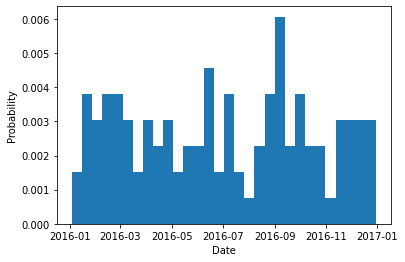

In [249]:
dates = transactions.loc[transactions["fraud_flag"] > 0]["transaction_date"]
plt.hist(dates, density=True, bins=30)
plt.ylabel('Probability')
plt.xlabel('Date');

Analysing `card_number`

In [250]:
transactions.groupby('card_number').sum().sort_values('fraud_flag', ascending=False).loc[transactions.groupby('card_number').sum()["fraud_flag"] > 0]["fraud_flag"]

card_number
7697-2274-6431-6408    2
1290-5480-3763-3387    2
8231-5519-1948-3400    2
9604-6821-2861-8084    2
3620-5235-2101-3391    2
                      ..
1519-5130-5810-8539    1
9425-1481-6545-6190    1
1655-7617-4318-5963    1
1661-3809-5334-2155    1
9386-8854-6115-4075    1
Name: fraud_flag, Length: 98, dtype: int64

Analysing `card_family`

In [251]:
transactions.groupby('card_family').sum().sort_values('fraud_flag', ascending=False)["fraud_flag"]/transactions.groupby('card_family').count().sort_values('fraud_flag', ascending=False)["fraud_flag"]

card_family
Premium     0.010978
Gold        0.010726
Platinum    0.011038
Name: fraud_flag, dtype: float64

In [252]:
transactions.groupby('card_family').sum().sort_values('fraud_flag', ascending=False)["fraud_flag"]

card_family
Premium     45
Gold        39
Platinum    25
Name: fraud_flag, dtype: int64

Analysing `customer_id`

In [253]:
transactions.groupby('customer_id').sum().sort_values('fraud_flag', ascending=False)["fraud_flag"]

customer_id
36771    2
60926    2
95072    2
16029    2
28038    2
        ..
38739    0
38556    0
38543    0
38368    0
99952    0
Name: fraud_flag, Length: 482, dtype: int64

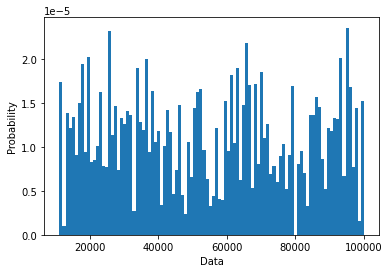

In [254]:
plt.hist(transactions["customer_id"], density=True, bins=100)
plt.ylabel('Probability')
plt.xlabel('Data');

Two hypothesis were that frauds could happen in a row to a customer or just happen one time for customer, but none of them could be confirmed.

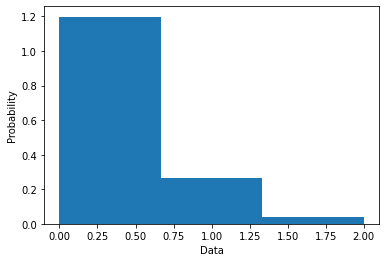

In [255]:
plt.hist(transactions.groupby('customer_id').sum().sort_values('fraud_flag', ascending=False)["fraud_flag"], density=True, bins=3)
plt.ylabel('Probability')
plt.xlabel('Data');

Analysing `age`

In [256]:
transactions.groupby('age').sum().sort_values('fraud_flag', ascending=False)["fraud_flag"]

age
42    8
41    8
30    7
48    6
32    5
22    5
24    5
39    5
29    5
35    4
33    4
50    4
31    4
23    4
37    3
27    3
38    3
26    3
36    3
40    2
25    2
43    2
46    2
47    2
34    2
49    2
20    2
21    1
28    1
44    1
45    1
Name: fraud_flag, dtype: int64

In [257]:
transactions.groupby('age').sum().sort_values('fraud_flag', ascending=False)["fraud_flag"]/transactions.groupby('age').count().sort_values('fraud_flag', ascending=False)["fraud_flag"]

age
20    0.008734
21    0.010417
22    0.015974
23    0.010959
24    0.013550
25    0.007117
26    0.009091
27    0.007692
28    0.003571
29    0.020325
30    0.014768
31    0.013652
32    0.014006
33    0.010870
34    0.006689
35    0.016064
36    0.011364
37    0.007009
38    0.009554
39    0.018868
40    0.008547
41    0.015717
42    0.019277
43    0.010695
44    0.002882
45    0.003049
46    0.007326
47    0.004149
48    0.014184
49    0.006006
50    0.015444
Name: fraud_flag, dtype: float64

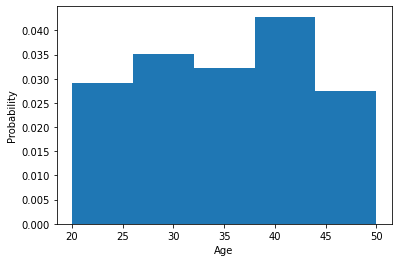

In [258]:
ages = transactions.loc[transactions["fraud_flag"] > 0]["age"]
plt.hist(ages, density=True, bins=5)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Age');

Analysing `vintage_group`

In [259]:
transactions.groupby('vintage_group').sum().sort_values('fraud_flag', ascending=False)["fraud_flag"]

vintage_group
1    54
2    28
3    27
Name: fraud_flag, dtype: int64

In [260]:
transactions.groupby('vintage_group').sum().sort_values('fraud_flag', ascending=False)["fraud_flag"]/transactions.groupby('vintage_group').count().sort_values('fraud_flag', ascending=False)["fraud_flag"]

vintage_group
1    0.012108
2    0.012238
3    0.008303
Name: fraud_flag, dtype: float64

Analysing `value` and `credit_limit`

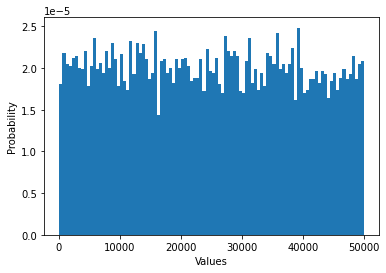

In [261]:
plt.hist(transactions["value"], density=True, bins=100)
plt.ylabel('Probability')
plt.xlabel('Values');

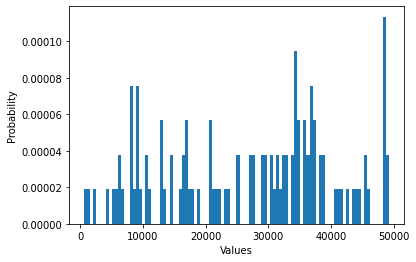

In [262]:
plt.hist(frauds["value"], density=True, bins=100)
plt.ylabel('Probability')
plt.xlabel('Values');

This one I tried to observe if frauds have any pattern in relation to credit_limit, like, if frauds has big or small values in relation to credit_limit, but they have the same distribution the group of all transactions.

In [263]:
transactions["value"]/transactions["credit_limit"]

0        0.121902
1        1.781733
2       11.006000
3        1.980895
4        0.012261
          ...    
9995     0.067500
9996     2.263583
9997     1.071294
9998     0.065612
9999     0.760600
Length: 10000, dtype: float64

In [264]:
frauds["value"]/frauds["credit_limit"]

102      0.066514
219      0.122739
336      0.064942
494      1.419853
560      0.238340
          ...    
9841     2.422000
9881    18.353000
9933     0.032851
9973     0.184744
9993     1.372615
Length: 109, dtype: float64

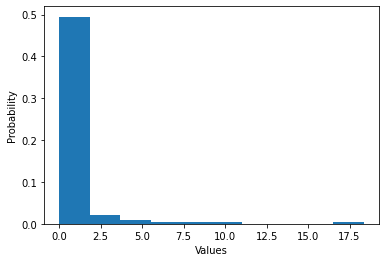

In [265]:
plt.hist(frauds["value"]/frauds["credit_limit"], density=True, bins=10)
plt.ylabel('Probability')
plt.xlabel('Values');

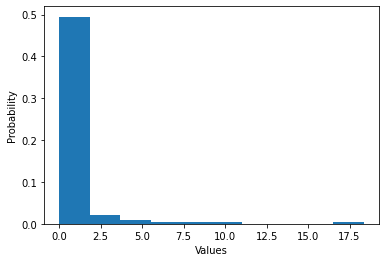

In [266]:
plt.hist(frauds["value"]/frauds["credit_limit"], density=True, bins=10)
plt.ylabel('Probability')
plt.xlabel('Values');

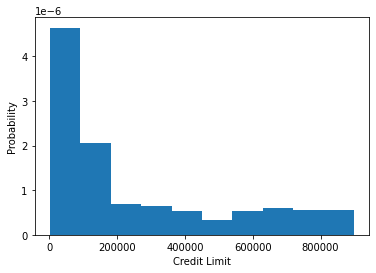

In [267]:
plt.hist(transactions["credit_limit"], density=True, bins=10)
plt.ylabel('Probability')
plt.xlabel('Credit Limit');

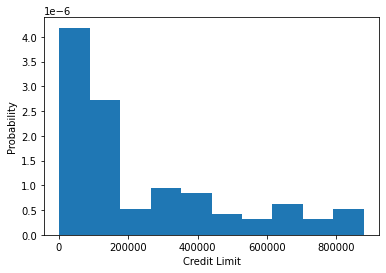

In [268]:
plt.hist(frauds["credit_limit"], density=True, bins=10)
plt.ylabel('Probability')
plt.xlabel('Credit Limit');

The diference between distribution of frauds and transactions credit limit are minimum.

Analysing `customer_id`

Trying to see if has some pattern in `customer_id` of frauds.

In [269]:
frauds["customer_id"].unique()

array([21111, 16420, 90833, 53797, 69171, 87306, 76008, 30400, 81662,
       61332, 37643, 32108, 26034, 70762, 11690, 79161, 71365, 56879,
       51908, 29686, 86100, 35402, 34035, 68752, 60926, 38711, 41731,
       95072, 42497, 81396, 52744, 34083, 42937, 87270, 60164, 14547,
       99130, 78843, 25881, 28038, 61186, 93075, 40274, 83124, 93684,
       62968, 36771, 24049, 17722, 82406, 38471, 68010, 18438, 17727,
       92155, 35596, 70548, 14238, 64111, 11887, 68259, 87034, 37292,
       61838, 78862, 68567, 28847, 46637, 24722, 19277, 13320, 65775,
       41412, 85400, 81000, 45677, 11486, 33423, 51714, 84333, 52705,
       84463, 72302, 50434, 77470, 16029, 66351, 89243, 56647, 35750,
       39362, 88046, 19186, 39128, 89895, 65624, 54582])

In this one I was trying to discover if has some pattern by customer where the fraud was made after several transactions or with some days in differance, but looking in some examples I found none pattern.


In [270]:
transactions.loc[ transactions["customer_id"] == frauds["customer_id"].unique()[0] ].sort_values('transaction_date')

,id,card_number,transaction_date,value,segment,fraud_flag,card_family,credit_limit,customer_id,age,vintage_group
2358,38539077,4246-1369-3659-8804,2016-01-22,18103,21,0,Platinum,105000,21111,43,2
4833,56132129,4246-1369-3659-8804,2016-01-27,11027,17,0,Platinum,105000,21111,43,2
412,35361185,4246-1369-3659-8804,2016-02-10,45600,20,0,Platinum,105000,21111,43,2
8784,77153379,4246-1369-3659-8804,2016-02-19,27692,18,0,Platinum,105000,21111,43,2
9870,32960540,4246-1369-3659-8804,2016-02-23,47100,14,0,Platinum,105000,21111,43,2
4894,51839811,4246-1369-3659-8804,2016-03-04,36577,11,0,Platinum,105000,21111,43,2
9147,25769426,4246-1369-3659-8804,2016-03-31,47857,12,0,Platinum,105000,21111,43,2
6609,80880958,4246-1369-3659-8804,2016-04-20,19259,17,0,Platinum,105000,21111,43,2
102,50558449,4246-1369-3659-8804,2016-05-06,6984,23,1,Platinum,105000,21111,43,2
8215,61733247,4246-1369-3659-8804,2016-05-09,41730,24,0,Platinum,105000,21111,43,2


In [271]:
transactions.loc[ transactions["customer_id"] == frauds["customer_id"].unique()[5] ].sort_values('transaction_date')

,id,card_number,transaction_date,value,segment,fraud_flag,card_family,credit_limit,customer_id,age,vintage_group
580,26555772,5734-5619-8469-4044,2016-01-11,683,22,1,Gold,36000,87306,30,1
35,11264842,5734-5619-8469-4044,2016-02-04,891,12,0,Gold,36000,87306,30,1
9715,69999647,5734-5619-8469-4044,2016-03-11,30714,14,0,Gold,36000,87306,30,1
9600,55822635,5734-5619-8469-4044,2016-03-14,42273,20,0,Gold,36000,87306,30,1
9465,65651562,5734-5619-8469-4044,2016-03-18,13329,21,0,Gold,36000,87306,30,1
695,11888859,5734-5619-8469-4044,2016-03-19,19067,19,0,Gold,36000,87306,30,1
3096,39932054,5734-5619-8469-4044,2016-03-20,38494,12,0,Gold,36000,87306,30,1
3423,28350944,5734-5619-8469-4044,2016-03-24,30400,15,0,Gold,36000,87306,30,1
8401,51336470,5734-5619-8469-4044,2016-04-04,34446,17,0,Gold,36000,87306,30,1
1889,94727068,5734-5619-8469-4044,2016-05-07,46836,11,0,Gold,36000,87306,30,1


This one was trying to look for a pattern in the days of frauds.

In [272]:
frauds.sort_values('transaction_date')[20:]

,id,card_number,transaction_date,value,segment,fraud_flag,card_family,credit_limit,customer_id,age,vintage_group
4142,55429304,9030-1667-6058-6173,2016-03-03,48514,15,1,Premium,426000,61186,41,1
4650,80787923,5129-6974-6371-2964,2016-03-06,17320,24,1,Gold,31000,62968,44,1
1664,28195227,8231-5519-1948-3400,2016-03-10,16857,17,1,Premium,661000,71365,39,2
3980,73000031,2447-6299-5016-4953,2016-03-11,8980,23,1,Premium,497000,25881,25,3
8066,87470159,7214-4915-6387-5429,2016-03-11,32198,21,1,Platinum,172000,72302,22,1
...,...,...,...,...,...,...,...,...,...,...,...
6082,30763806,6722-7299-6082-7974,2016-12-17,40751,21,1,Gold,34000,87034,36,2
1905,41668436,4012-7774-6690-7055,2016-12-23,6477,20,1,Platinum,159000,29686,36,2
2267,95859840,4856-2191-9879-6388,2016-12-24,34214,21,1,Gold,11000,38711,43,1
9933,30494187,9018-5320-5729-5393,2016-12-31,14586,20,1,Premium,444000,54582,29,3


Last, i tried to look for a pattern in the gaps of days of frauds, but I found none too.

In [273]:
count = 0
last = 0
gaps = []
for index, row in transactions.iterrows():
    count += 1
    if row["fraud_flag"] == 1:
      gaps.append( index - last)
      last = index

print(gaps)

[102, 117, 117, 158, 66, 20, 20, 46, 55, 77, 23, 16, 60, 40, 20, 20, 657, 50, 60, 169, 12, 68, 36, 57, 97, 51, 53, 262, 337, 298, 55, 2, 101, 109, 20, 179, 13, 96, 211, 30, 82, 80, 20, 69, 67, 23, 8, 67, 156, 67, 31, 67, 64, 18, 30, 519, 53, 17, 85, 9, 84, 64, 318, 34, 23, 40, 7, 3, 137, 12, 46, 47, 5, 13, 42, 130, 32, 226, 33, 58, 31, 406, 102, 194, 62, 59, 57, 186, 103, 203, 130, 70, 319, 14, 18, 141, 33, 155, 216, 79, 175, 109, 6, 8, 99, 40, 52, 40, 20]


Finally, throught my analysis and observation of the data, I think that the frauds has no trivial pattern or correlation, maybe with some Machine Learning model is possible to predict a fraud, but just with a simple statistical analysis was not possible to decide wheter or not a transaction was a fraud.

# Prediction

In [274]:
transac_to_model = transactions.copy()
first_day = transac_to_model.sort_values('transaction_date').iloc[0]["transaction_date"]

transac_to_model["transaction_date"] = transac_to_model["transaction_date"] - first_day
transac_to_model["transaction_date"] = transac_to_model["transaction_date"].dt.days.astype('int16')

# Label Encoding using the ranked based by credit limit 
transac_to_model.replace({'card_family': {'Gold': 0, 'Platinum': 1, 'Premium':2 }}, inplace=True)

transac_to_model = transac_to_model.drop(columns=["card_number", "id", "customer_id","vintage_group", "segment"])

In [275]:
transac_to_model.head()

,transaction_date,value,segment,fraud_flag,card_family,credit_limit,age,vintage_group
0,114,23649,25,0,1,194000,23,3
1,41,26726,16,0,0,15000,48,3
2,305,22012,14,0,0,2000,23,1
3,27,37637,17,0,0,19000,44,2
4,76,5113,14,0,2,417000,42,3


In [276]:
x = transac_to_model.loc[:,transac_to_model.columns!='fraud_flag'].values
y = np.ravel(transac_to_model.loc[:,transac_to_model.columns=='fraud_flag'].values)

Considering that just a few transactions are frauds, if the model consider all transactions as not fraudlent the accuracy will be:

In [277]:
1 - frauds.shape[0]/transactions.shape[0]

0.9891

Let's test some classifiers.

In [278]:
classifier_knn = KNeighborsClassifier()

params = {
    'n_neighbors': (40,50,60),
}

best_classifier_knn = GridSearchCV(classifier_knn, params, scoring='accuracy', n_jobs=-1, cv=2)

classifier_knn = best_classifier_knn.fit(x,y)

print("Best params:")
print(best_classifier_knn.best_params_)
print("\n")
print("Best scores:")
print(best_classifier_knn.best_score_)

Best params:
{'n_neighbors': 40}


Best scores:
0.9891


In [279]:
classifier_mlp = MLPClassifier()

params = {
    'hidden_layer_sizes': ((100,),(100,100),(50,50)),
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05, 0.1],
    'learning_rate': ['constant','adaptive'],
}

best_classifier_mlp = GridSearchCV(classifier_mlp, params, scoring='accuracy', n_jobs=-1, cv=2)

classifier_mlp = best_classifier_mlp.fit(x,y)

print("Best params:")
print(best_classifier_mlp.best_params_)
print("\n")
print("Best scores:")
print(best_classifier_mlp.best_score_)

Best params:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


Best scores:
0.9891


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [280]:
classifier_ada = AdaBoostClassifier(random_state=0)

params = {
    'n_estimators': (600,700,800),
    'learning_rate': (0.05, 0.1,1),
}

best_classifier_ada = GridSearchCV(classifier_ada, params, scoring='accuracy', n_jobs=-1, cv=2)

classifier_ada = best_classifier_ada.fit(x,y)

print("Best params:")
print(best_classifier_ada.best_params_)
print("\n")
print("Best scores:")
print(best_classifier_ada.best_score_)

Best params:
{'learning_rate': 0.05, 'n_estimators': 600}


Best scores:
0.9891


In [281]:
classifier_gradient = GradientBoostingClassifier(random_state=0)

params = {
    'n_estimators': (400,500,600),
    'learning_rate': (0.001,0.01, 0.05, 0.1),
}

best_classifier_gradient = GridSearchCV(classifier_gradient, params, scoring='accuracy', n_jobs=-1, cv=2)

classifier_gradient = best_classifier_gradient.fit(x,y)

print("Best params:")
print(best_classifier_gradient.best_params_)
print("\n")
print("Best scores:")
print(best_classifier_gradient.best_score_)

Best params:
{'learning_rate': 0.001, 'n_estimators': 400}


Best scores:
0.9891


In [282]:
classifier_random_forest = RandomForestClassifier(random_state=0)

params = {
    'n_estimators': (800,900,1000),
    "max_depth": [9, 10, 11,12],
}

best_classifier_random_forest = GridSearchCV(classifier_random_forest, params, scoring='accuracy', n_jobs=-1, cv=2)

classifier_random_forest = best_classifier_random_forest.fit(x,y)

print("Best params:")
print(best_classifier_random_forest.best_params_)
print("\n")
print("Best scores:")
print(best_classifier_random_forest.best_score_)

Best params:
{'max_depth': 9, 'n_estimators': 800}


Best scores:
0.989


Watching the results it's clear to see that none model was capable of learn a pattern in the data to infer if a transaction is as fraud or not. Every model obtained 0.9891 as score and this represents a scenario that the hypothesis is that none transaction is fraudulent. Maybe with more data from fraudulent transactiona will be possible to develope a model with higher accuracy.